# Optimize molecular geometry using the variational method.
We try to optimize molecular geometries of various molecules by optimizing $E(x, \theta) = \langle \hat H_e(x) \rangle_{|\psi(\theta)\rangle}$ over the parameters $\theta$ and $x$(nuclear co-ordinates).

In [322]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecular_hamiltonian, hf_state
from pennylane.devices.default_qubit import DefaultQubit

from functools import partial # "freezes" some portion of the function argument. Returns a nested wrapper fn for the rest of the arguments. See https://docs.python.org/3/library/functools.html
from matplotlib import pyplot as ppl

In [323]:

symbols = ["H", "H", "H"]
#x_init = np.array([0.028, 0.054, 0.0, 0.986, 1.610, 0.0, 1.855, 0.002, 0.0], requires_grad=True) # the molecular geometry as computed from the Hartree Fock state ie minimise E(x, theta=0). This is well-known and provides a good starting point to reach convergence quickly(since the optimal state is not too far off from the HF state).
charge = 1


x_init = np.array([0, 0, 0, 2, 1, 0, 1.5, 0, 0], requires_grad=True) # a somewhat arbitrary starting position.
qubits = molecular_hamiltonian(symbols=symbols, coordinates=x_init, charge=charge)[1] # number of qubits required for the simulation. It is independent of x so just compute it at the starting x

# hamiltonian as a function of the nuclear coordinates x
def H(x): 
    return molecular_hamiltonian(symbols=symbols, coordinates=x, charge=charge)[0]

print("\nQubits required:", qubits, "\n\n(Electronic) Hamiltonian at initial(H-F) x:\n", H(x_init))

# classical and quantum devices used
q_dev = DefaultQubit(wires=qubits)
c_opt_x = qml.GradientDescentOptimizer(stepsize=0.8)
c_opt_theta = qml.GradientDescentOptimizer(stepsize=0.4)


Qubits required: 6 

(Electronic) Hamiltonian at initial(H-F) x:
   (-0.4011347425315228) [Z4]
+ (-0.4011347425315228) [Z5]
+ (-0.04077816517547611) [Z3]
+ (-0.04077816517547608) [Z2]
+ (0.2487864343410179) [Z0]
+ (0.24878643434101794) [Z1]
+ (0.30131978153186867) [I0]
+ (-0.01174445061943261) [Y1 Y3]
+ (-0.01174445061943261) [X1 X3]
+ (-0.009308647606361093) [Y2 Y4]
+ (-0.009308647606361093) [X2 X4]
+ (0.0078010602830830625) [Y3 Y5]
+ (0.0078010602830830625) [X3 X5]
+ (0.00877382892570127) [Y0 Y2]
+ (0.00877382892570127) [X0 X2]
+ (0.10720766864765069) [Z0 Z2]
+ (0.10720766864765069) [Z1 Z3]
+ (0.11441125443771559) [Z2 Z4]
+ (0.11441125443771559) [Z3 Z5]
+ (0.1291370276313948) [Z0 Z4]
+ (0.1291370276313948) [Z1 Z5]
+ (0.14058913696142994) [Z2 Z5]
+ (0.14058913696142994) [Z3 Z4]
+ (0.1422221802287385) [Z0 Z3]
+ (0.1422221802287385) [Z1 Z2]
+ (0.1603516020369151) [Z2 Z3]
+ (0.16198698042423643) [Z0 Z1]
+ (0.16327859163709035) [Z0 Z5]
+ (0.16327859163709035) [Z1 Z4]
+ (0.177210316817442

In [324]:
# the circuit that prepares the variational state |Ψ(θ1,θ2)⟩=cos(θ1/2)[cos(θ2/2)|110000⟩−sin(θ2/2)|000011⟩]−sin(θ1/2)|001100⟩ by 110000 -> DoubleExcitation(01,23) -> cos(θ1/2)|110000⟩ - sin(θ1/2)|001100⟩ and then using a DoubleExcitation(01,45) to get the |110000⟩ part into cos(θ2/2)|110000⟩−sin(θ2/2)|000011⟩ giving the required |Ψ(θ1,θ2)⟩.
def circuit(theta: tuple):
    qml.BasisState(hf_state(electrons=2, orbitals=6), wires=range(qubits)) # initial state is H-F state = qml.qchem.hf_state(electrons=2, orbitals=6) = |110000⟩
    qml.DoubleExcitation(theta[0], wires = range(4))
    qml.DoubleExcitation(theta[1], wires=[0, 1, 4, 5])

# computes expectation value of observable in the state psi(theta)
@qml.qnode(device=q_dev)
def expectation(theta: tuple, observable):
    circuit(theta) # the theta is only to prepare psi
    return qml.expval(observable) # the expval is for the wavefunction that the qubits are in after circuit(theta) has been applied and so is ⟨Ψ(θ1,θ2)|H(x)|Ψ(θ1,θ2)⟩

# our cost fn(x, theta) = expectation(H(x)) in psi(theta)
def cost(x, theta: tuple):
    return expectation(theta, observable=H(x))

In [325]:
### The computation of grad(cost) ###

# returns canonical basis vector e_i
def ei(sz, i):
    ans = np.zeros(sz); ans[i] = 1.0
    return ans

# computes gradient of function f at x using a central-difference approximation with radius=epsilon
def grad_f(f, x, epsilon:float=0.01):
    return [(f(x + epsilon*ei(len(x), i)) - f(x - epsilon*ei(len(x), i)))*(2*epsilon)**-1 for i in range(len(x))]

# computes grad_x(cost). grad_x(cost)_i = <psi|grad_xi(H)|psi> = expval(grad_x(H)[i]).
def grad_x(x, theta, epsilon:float=0.01):
    return [expectation(theta, dxi) for dxi in grad_f(H, x, epsilon=epsilon)]

# We leave grad_theta(cost) to the Quantum Circuit, parameter-shift and PennyLane.

In [326]:
# optimizes x and theta. To minimise: cost = Energy of system. Theta is (default) initially 0, 0 to indicate that psi_init = the HF state.
def optimize(x_init=x_init, theta_init=np.array([0.0, 0.0], requires_grad=True), tol: float=1e-7, max_iter: int=100):
    xvals = [x_init]
    thetas = [theta_init]
    energies = [cost(x_init, theta_init)] # redundant but okay.
    
    for __ in range(max_iter):
        
        theta_updated = c_opt_theta.step(partial(cost, xvals[-1]), thetas[-1]) # the objective fn is as given since we are trying to optimize only theta at the given x. Alternately set xvals[-1].require_grad to False and then send in cost as the objective function.

        x_updated = np.array(c_opt_x.apply_grad(grad_x(xvals[-1], theta_updated), xvals[-1]))
        

        if abs(cost(x_updated, theta_updated) - energies[-1]) < tol: break

        xvals.append(x_updated)
        thetas.append(theta_updated)
        energies.append(cost(x_updated, theta_updated))
    return xvals, thetas, energies

In [327]:
# can try and generalize this with more work and a header(first row string) argument to implement a simple version of the PrettyTable class in module prettytable
def pretty_print(*args):
    horiz = ('+' + '-'*7) + ('+' + '-'*15)*4 + ('+' + '-'*63) + '+'
    print(horiz)
    print('|Iter\t|    Energy(Ha)\t|B.L.(H1-H2, Å)\t|B.L.(H2-H3, Å)\t|B.L.(H3-H1, Å)\t|\t\t\tWave Function |Ψ(θ1,θ2)⟩\t\t|')
    print(horiz)
    for row in zip(*args):
        print(('| {:>3}\t|' + '    {:>8.6f}\t|'*4 + '({:>7.6f})|110000⟩ + ({:>7.6f})|001100⟩ + ({:>7.6f})|000011⟩\t|').format(*row))
    print(horiz)

In [328]:
xvals, thetas, energies = optimize()
thetas = [(float(theta[0]), float(theta[1])) for theta in thetas]
energies = [float(energy) for energy in energies]
args = [[], [], [], [], [], [], [], []]
bohr_rad_to_angstrom = 0.529177210903
for i, (x, theta, energy) in enumerate(zip(xvals, thetas, energies)):
    if i % 5 != 0: continue
    args[0].append(i)
    args[1].append(energy)
    args[2].append(np.linalg.norm(x[0:3] - x[3:6]) * bohr_rad_to_angstrom)
    args[3].append(np.linalg.norm(x[3:6] - x[6:9]) * bohr_rad_to_angstrom)
    args[4].append(np.linalg.norm(x[6:9] - x[0:3]) * bohr_rad_to_angstrom)
    args[5].append(np.cos(theta[0]) * np.cos(theta[1]))
    args[6].append(-np.sin(theta[0]))
    args[7].append(-np.cos(theta[0]) * np.sin(theta[1]))
pretty_print(*args)

# initial version of table using just tabs
# print('Iter\tEnergy(Ha)\tBond Length(Å)')
# for i, (x, theta, energy) in enumerate(zip(xvals, thetas, energies)):
#     if i%5 == 0:
#         print('{:>2}\t{:>8.7f}\t{:>8.6f}'.format(i, energy, np.linalg.norm(x[0:3] - x[3:6]) * 0.529177210903))

+-------+---------------+---------------+---------------+---------------+---------------------------------------------------------------+
|Iter	|    Energy(Ha)	|B.L.(H1-H2, Å)	|B.L.(H2-H3, Å)	|B.L.(H3-H1, Å)	|			Wave Function |Ψ(θ1,θ2)⟩		|
+-------+---------------+---------------+---------------+---------------+---------------------------------------------------------------+
|   0	|    -1.154220	|    1.183276	|    0.591638	|    0.793766	|(1.000000)|110000⟩ + (-0.000000)|001100⟩ + (-0.000000)|000011⟩	|
|   5	|    -1.257488	|    1.306766	|    0.901304	|    0.895271	|(0.975621)|110000⟩ + (-0.177495)|001100⟩ + (-0.129070)|000011⟩	|
|  10	|    -1.264747	|    1.229509	|    0.926123	|    0.924956	|(0.963881)|110000⟩ + (-0.219754)|001100⟩ + (-0.150471)|000011⟩	|
|  15	|    -1.269442	|    1.148531	|    0.941894	|    0.941593	|(0.961586)|110000⟩ + (-0.221894)|001100⟩ + (-0.161600)|000011⟩	|
|  20	|    -1.272381	|    1.082414	|    0.955443	|    0.955347	|(0.961959)|110000⟩ + (-0.213378)|001100⟩ +

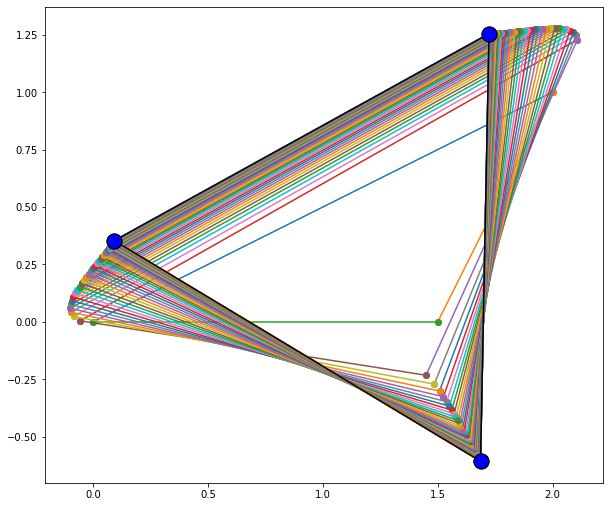

In [329]:
fig, axes = ppl.subplots()
fig.set_size_inches(10, 10)
axes.set_aspect('equal', adjustable='box')
for x in xvals:
    ppl.plot([x[0], x[3]], [x[1], x[4]], marker='o')
    ppl.plot([x[3], x[6]], [x[4], x[7]], marker='o')
    ppl.plot([x[6], x[0]], [x[7], x[1]], marker='o')
# darken the final geometry of the molecule. (x = xvals[-1] at the end of the loop, note)
ppl.plot([x[0], x[3]], [x[1], x[4]], marker='o', color='black', markerfacecolor='blue', markersize=15)
ppl.plot([x[3], x[6]], [x[4], x[7]], marker='o', color='black', markerfacecolor='blue', markersize=15)    
ppl.plot([x[6], x[0]], [x[7], x[1]], marker='o', color='black', markerfacecolor='blue', markersize=15)